***Importing libraries**

In [13]:
#core libraries
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#machine learning
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynoamialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

#set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

**Exploratory Data Analysis**

In [19]:
#Load the datasets
data = load_breast_cancer()
X = pd.DataFrame(data=data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [21]:
#the target is 0 for malignant and 1 for benign (we'll verify this)
print(f"features shape: {X.shape}" )
print(f"target shape: {y.shape}")
print("\nTarget value counts:")
print(y.value_counts())
print("\ntarget meaning:")
print(data.target_names)

features shape: (569, 30)
target shape: (569,)

Target value counts:
1    357
0    212
Name: count, dtype: int64

target meaning:
['malignant' 'benign']


**--Data Types and Basic Info--**

In [23]:
print("\nData types:")
print(X.dtypes)
print("\nDescriptive stadistics: ")
print(X.describe())


Data types:
mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst s

**--data quality and missing values--**

In [25]:
print("\nMissing values per feature")
print(X.isnull().sum())

#check for duplicates
print(f"\nNumber of duplicates in feature: {X.duplicated().sum}")


Missing values per feature
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

Number of duplicates in feature: <bound method Series.sum of 0      False
1      False
2

**Data Distribution**

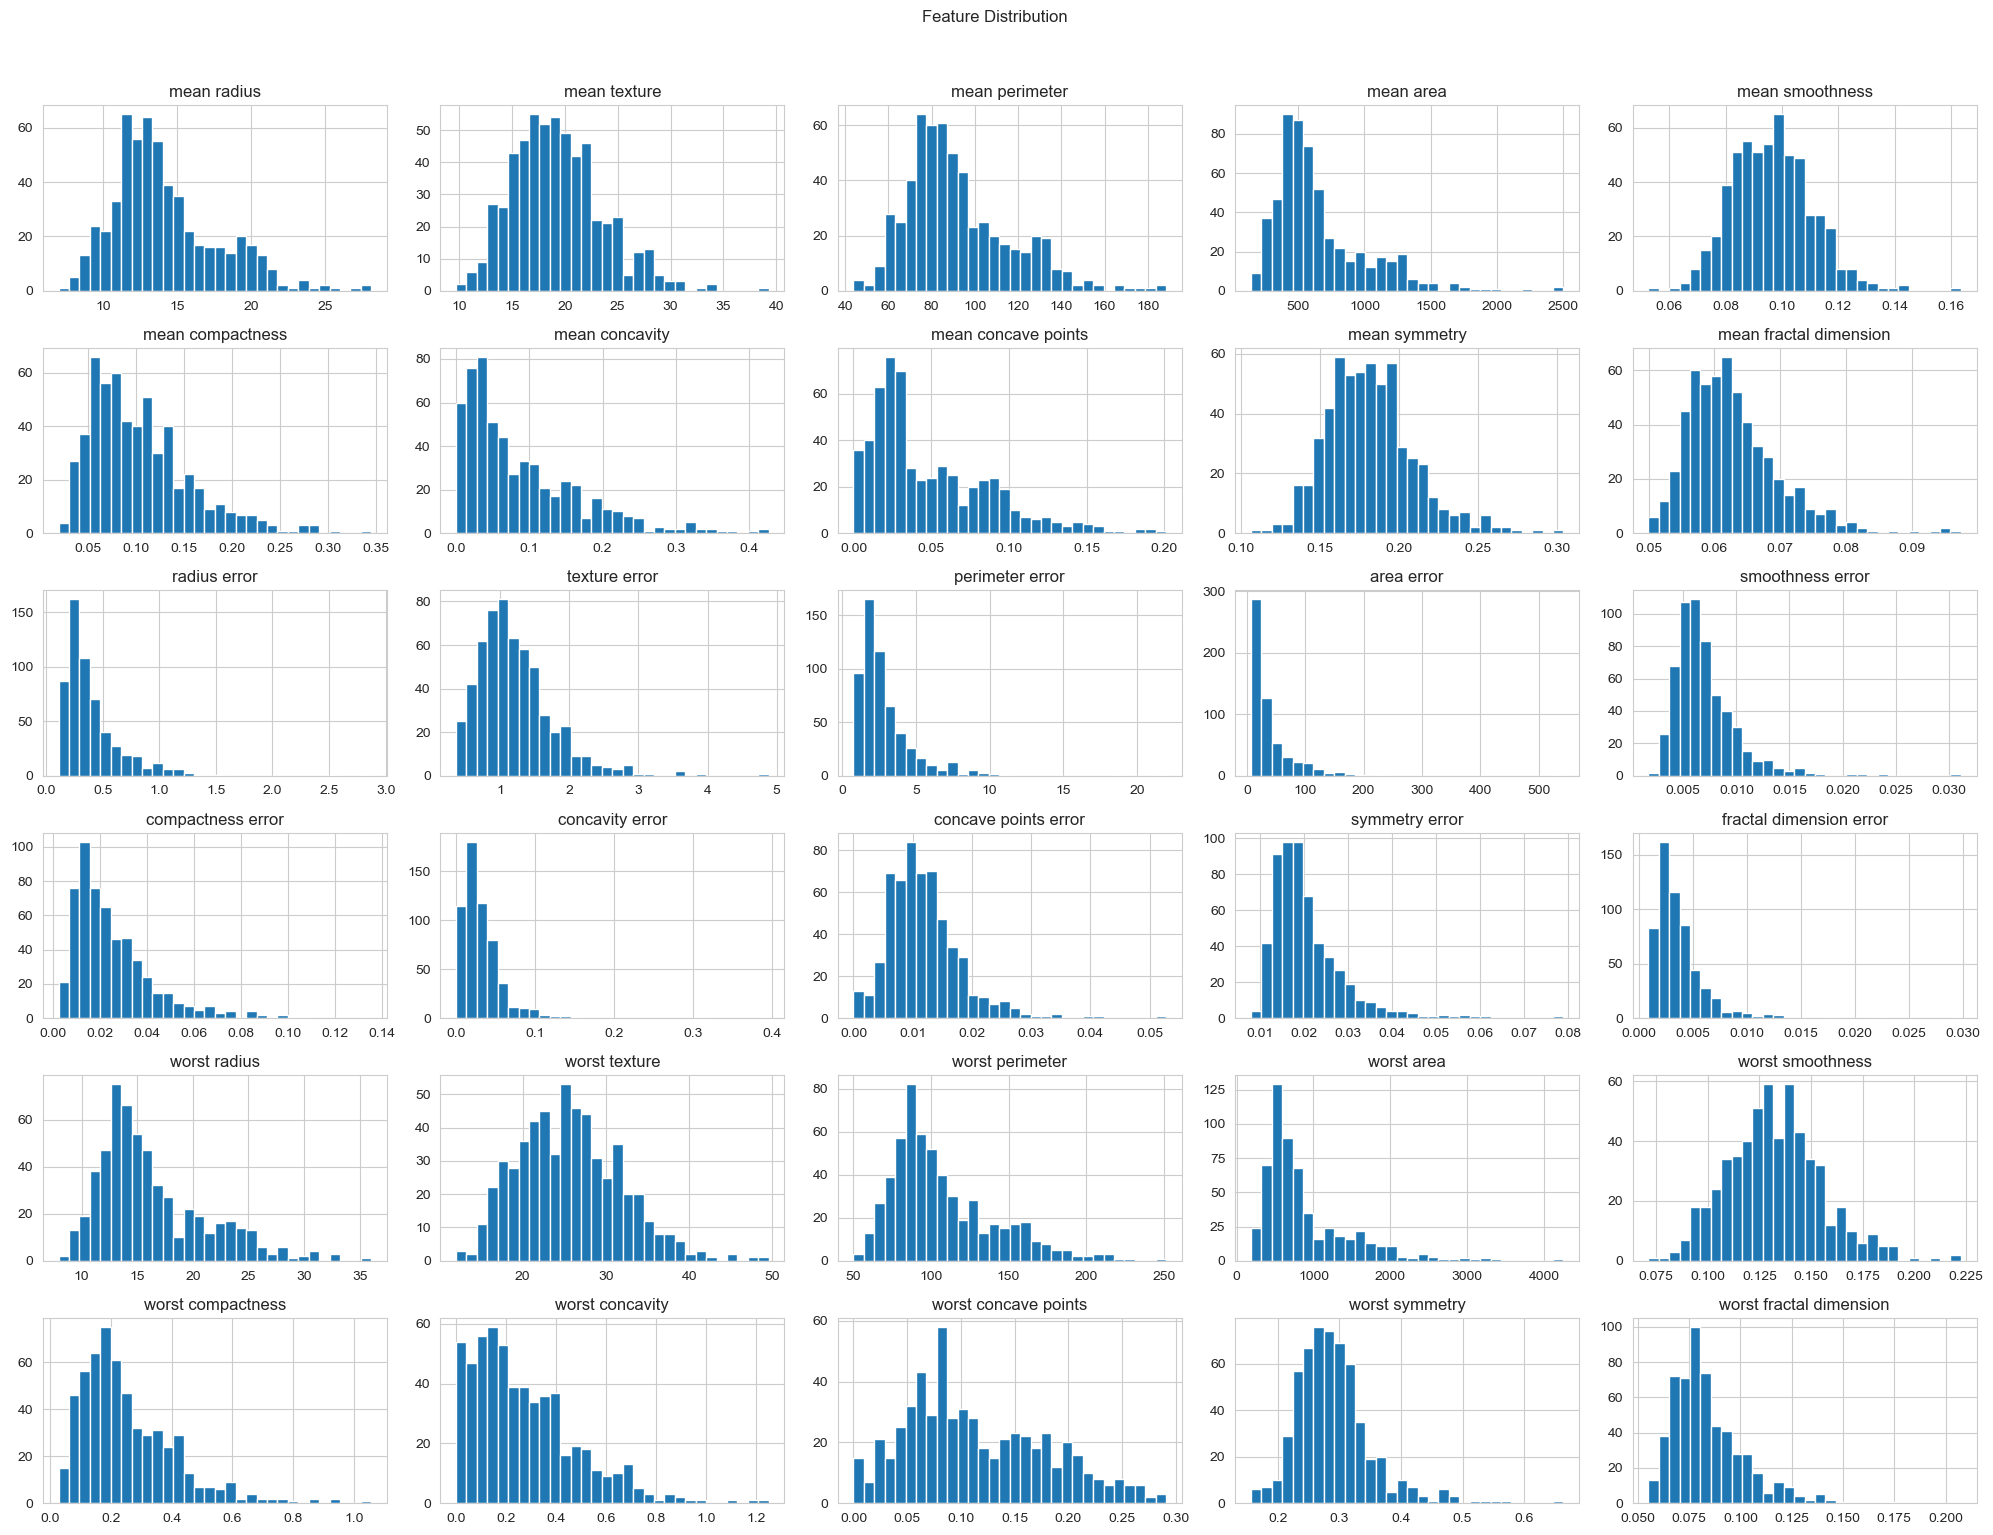

In [31]:
#plot distribution of all features
X.hist(bins= 30, figsize=(20,15))
plt.suptitle('Feature Distribution', y=1.02)
plt.tight_layout()
plt.show()

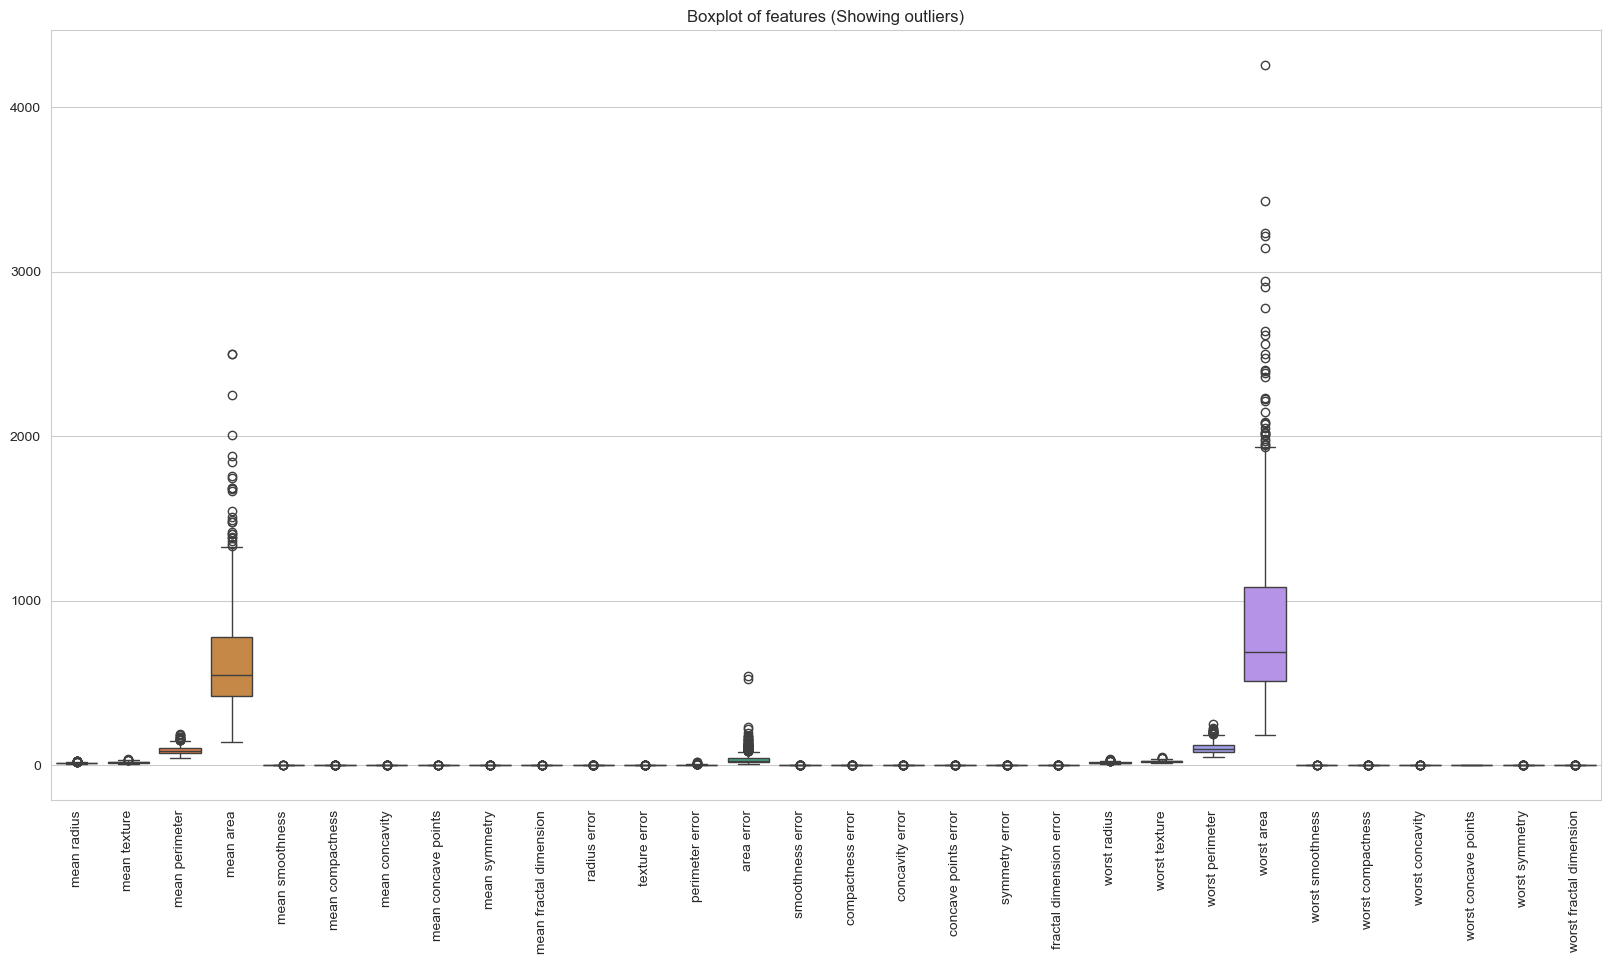

In [33]:
#boxplots for identify outliers
plt.figure(figsize=(20,10))
sns.boxplot(data=X)
plt.title('Boxplot of features (Showing outliers)')
plt.xticks(rotation=90)
plt.show()

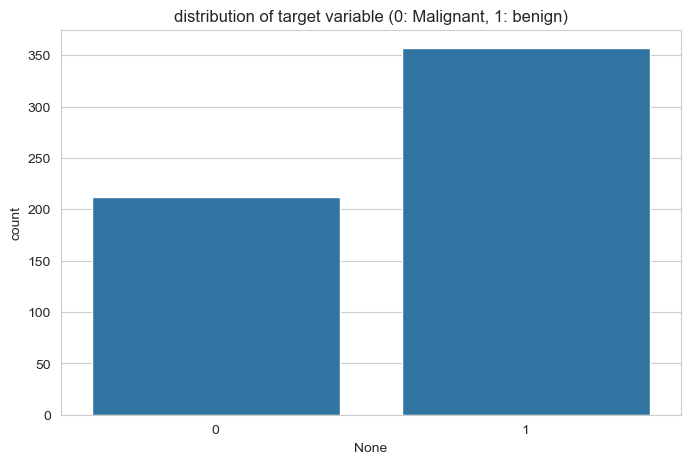

In [35]:
#distribution of target variable
plt.figure(figsize=(8,5))
sns.countplot(x=y)
plt.title('distribution of target variable (0: Malignant, 1: benign)')
plt.show()

**--correlation analysis--**

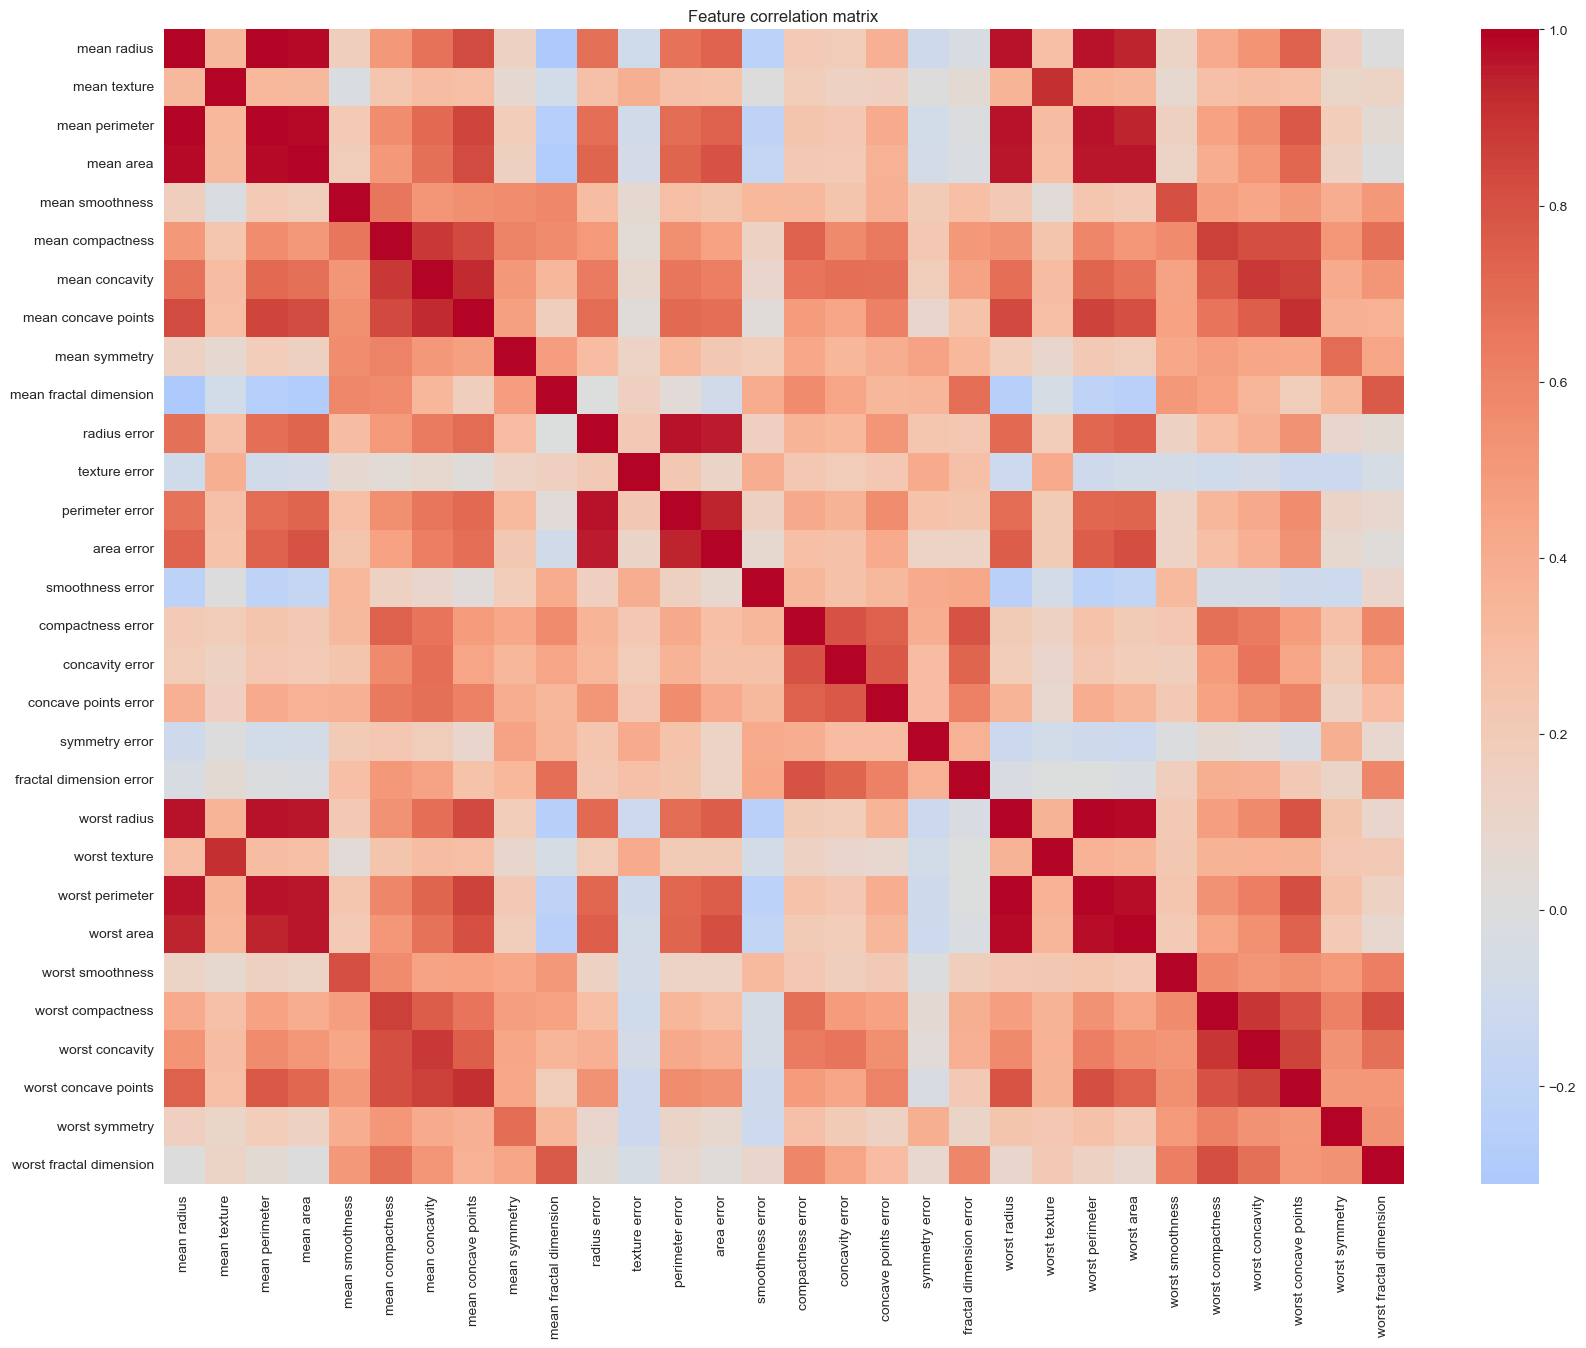

In [41]:
corr_matrix = X.corr()

#plot heatmap
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature correlation matrix')
plt.show()

In [43]:
#top correlations
corr_with_target = X.corrwith(y)
print("\nTop 10 features most correlated with target")
print(corr_with_target.abs().sort_values(ascending=False).head(10))


Top 10 features most correlated with target
worst concave points    0.793566
worst perimeter         0.782914
mean concave points     0.776614
worst radius            0.776454
mean perimeter          0.742636
worst area              0.733825
mean radius             0.730029
mean area               0.708984
mean concavity          0.696360
worst concavity         0.659610
dtype: float64


**Feature Engineering**

In [45]:
# Create interaction terms (example: worst radius * worst texture)
X['worst_radius_texture'] = X['worst radius'] * X['worst texture']
X['mean_concave_mean_concave'] = X['mean concave points'] * X['mean concavity']

# Log transform for highly skewed features (example: area features)
area_features = [col for col in X.columns if 'area' in col]
for feature in area_features:
    X[f'log_{feature}'] = np.log1p(X[feature])


Original number of features: 35
Number of components after PCA: 11
Explained variance ratio: [0.47928489 0.18278038 0.08386037 0.0623232  0.04799348 0.03457548
 0.02000735 0.01424797 0.01252403 0.01185888 0.00961105]


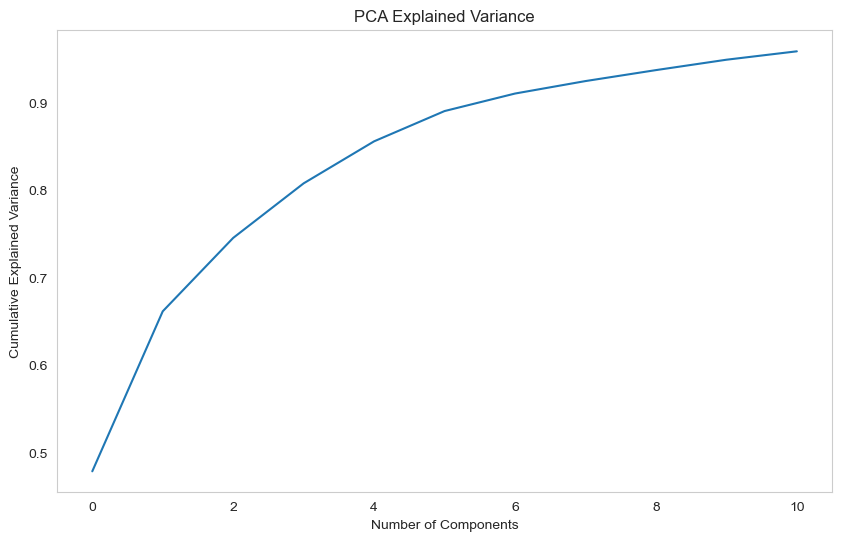

In [47]:
# First, we need to scale the data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

print(f"\nOriginal number of features: {X_scaled.shape[1]}")
print(f"Number of components after PCA: {X_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

In [49]:
# Select top k features using ANOVA F-value
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X, y)

# Get selected features
selected_features = X.columns[selector.get_support()]
print("\nSelected features:")
print(selected_features)


Selected features:
Index(['mean radius', 'mean perimeter', 'mean concave points', 'worst radius',
       'worst perimeter', 'worst area', 'worst concave points',
       'worst_radius_texture', 'log_mean area', 'log_worst area'],
      dtype='object')


In [57]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (455, 35)
Test set size: (114, 35)


In [59]:
print(X_train.head())

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
546        10.32         16.35           65.31      324.9          0.09434   
432        20.18         19.54          133.80     1250.0          0.11330   
174        10.66         15.15           67.49      349.6          0.08792   
221        13.56         13.90           88.59      561.3          0.10510   
289        11.37         18.89           72.17      396.0          0.08713   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
546           0.04994         0.01012             0.005495         0.1885   
432           0.14890         0.21330             0.125900         0.1724   
174           0.04302         0.00000             0.000000         0.1928   
221           0.11920         0.07860             0.044510         0.1962   
289           0.05008         0.02399             0.021730         0.2013   

     mean fractal dimension  ...  worst compactness  worst concavity

In [63]:
print(X_test.head())

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
256        19.55         28.77          133.60     1207.0          0.09260   
428        11.13         16.62           70.47      381.1          0.08151   
501        13.82         24.49           92.33      595.9          0.11620   
363        16.50         18.29          106.60      838.1          0.09686   
564        21.56         22.39          142.00     1479.0          0.11100   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
256           0.20630         0.17840              0.11440         0.1893   
428           0.03834         0.01369              0.01370         0.1511   
501           0.16810         0.13570              0.06759         0.2275   
363           0.08468         0.05862              0.04835         0.1495   
564           0.11590         0.24390              0.13890         0.1726   

     mean fractal dimension  ...  worst compactness  worst concavity

In [79]:
# Standardize features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
X_train_scaled

array([[-1.07200079, -0.6584246 , -1.0880801 , ..., -1.18613107,
        -1.10363151, -1.18353934],
       [ 1.74874285,  0.06650173,  1.75115682, ...,  1.6137028 ,
         0.82422284,  1.25924   ],
       [-0.97473376, -0.93112416, -0.99770871, ..., -1.03406673,
        -0.38895185, -1.07655774],
       ...,
       [ 0.39844772,  1.06867262,  0.50751384, ...,  0.49904568,
         0.15313752,  0.37621507],
       [ 0.85331409, -0.0380331 ,  0.9054796 , ...,  0.91898737,
         0.12981664,  0.86291862],
       [-0.91179628, -0.82431683, -0.87666079, ..., -0.97957272,
        -1.50043814, -0.96965534]])

# Example code (not run since our data has no missing values)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [83]:
# Initialize and train logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]  # probabilities for class 1

In [85]:
# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("\nBest parameters from grid search:")
print(grid_search.best_params_)

# Best model
best_logreg = grid_search.best_estimator_


Best parameters from grid search:
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
# Predict with best model
y_pred = best_logreg.predict(X_test_scaled)
y_pred_proba = best_logreg.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nClassification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))


Classification Metrics:
Accuracy: 0.9737
Precision: 0.9859
Recall: 0.9722
F1 Score: 0.9790
ROC AUC: 0.9964

Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.98      0.96        42
      benign       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



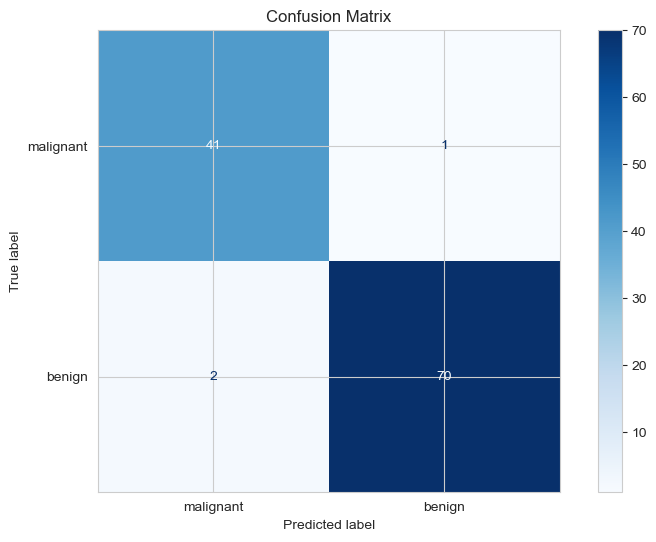

In [101]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

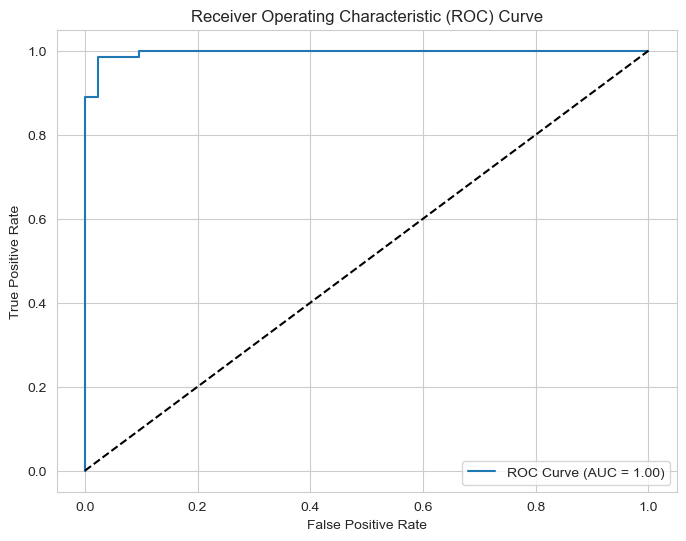

In [105]:
from sklearn.metrics import roc_curve
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

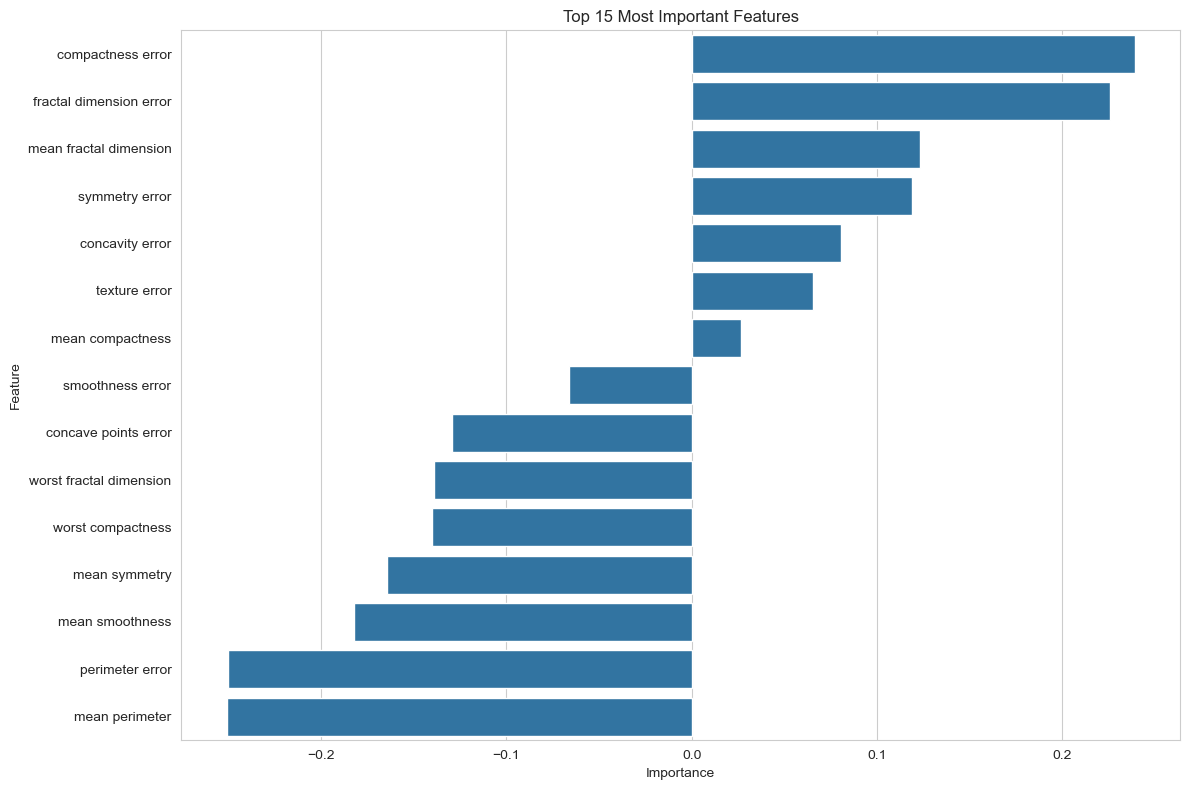

In [107]:
# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_logreg.coef_[0]
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

C:\Users\ShePlay\AppData\Local\Temp\ipykernel_13256\1807719637.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette=['red', 'green'])


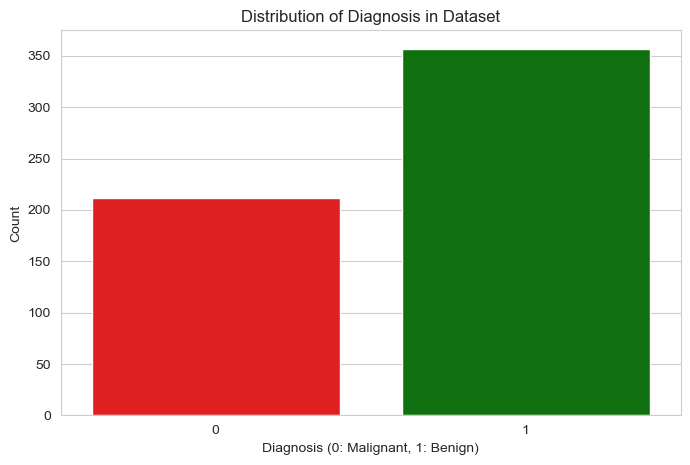

In [119]:
# 1. Distribution of diagnosis
plt.figure(figsize=(8, 5))
sns.countplot(x=y, palette=['red', 'green'])
plt.title('Distribution of Diagnosis in Dataset')
plt.xlabel('Diagnosis (0: Malignant, 1: Benign)')
plt.ylabel('Count')
plt.show()

C:\Users\ShePlay\AppData\Local\Temp\ipykernel_13256\443946883.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=X['worst radius'], palette=['red', 'green'])


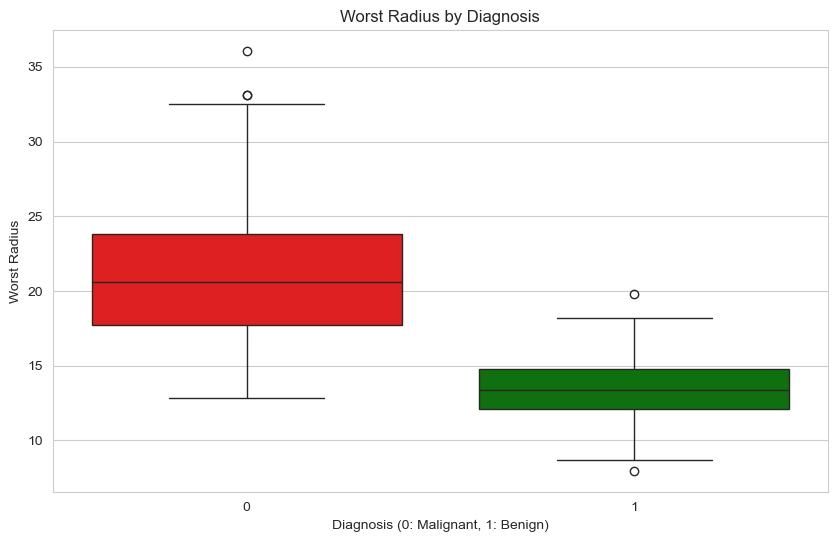

In [121]:
# 2. Feature distributions by diagnosis (example: worst radius)
plt.figure(figsize=(10, 6))
sns.boxplot(x=y, y=X['worst radius'], palette=['red', 'green'])
plt.title('Worst Radius by Diagnosis')
plt.xlabel('Diagnosis (0: Malignant, 1: Benign)')
plt.ylabel('Worst Radius')
plt.show()

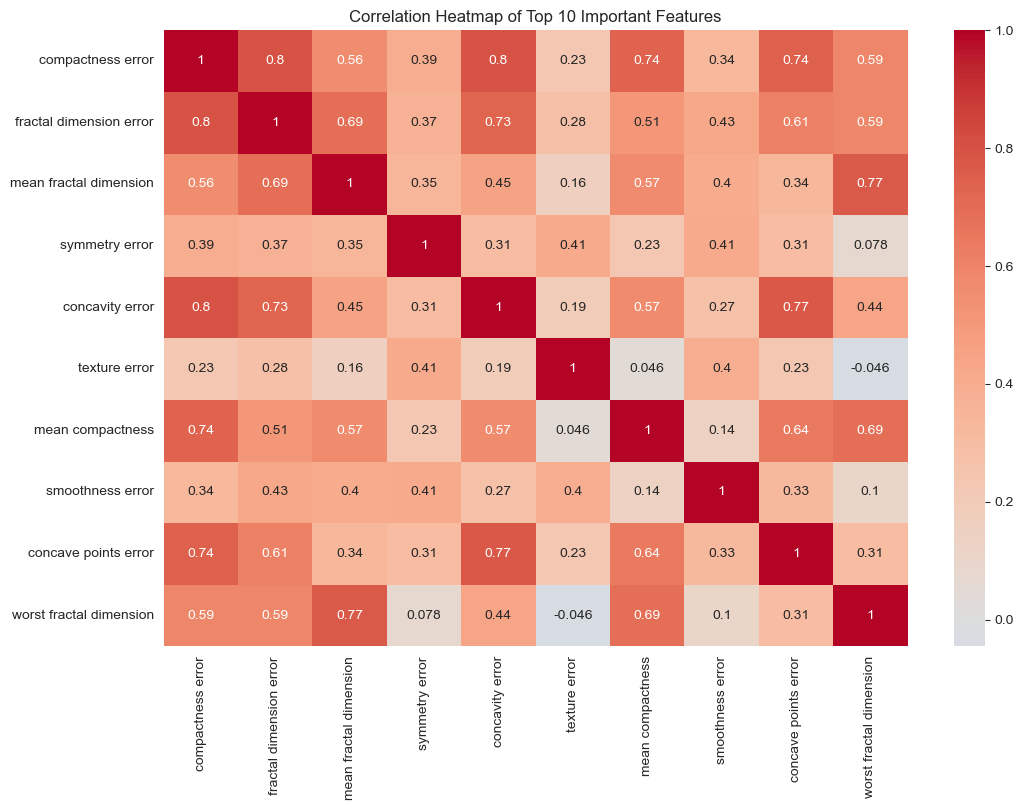

In [123]:
# 3. Correlation heatmap of top features
top_features = feature_importance['Feature'].head(10)
plt.figure(figsize=(12, 8))
sns.heatmap(X[top_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Top 10 Important Features')
plt.show()

C:\Users\ShePlay\AppData\Local\Temp\ipykernel_13256\1241427139.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


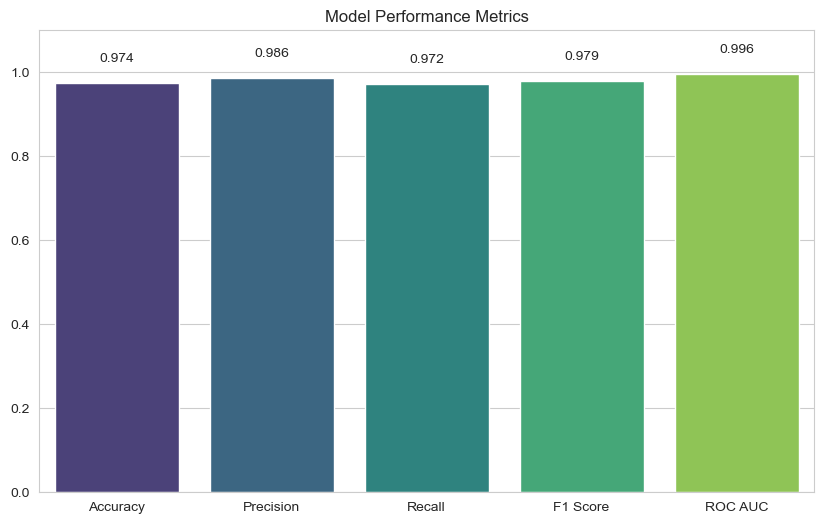

In [125]:
# 4. Model performance summary
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
values = [accuracy, precision, recall, f1, roc_auc]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.title('Model Performance Metrics')
plt.ylim(0, 1.1)
for i, v in enumerate(values):
    plt.text(i, v + 0.05, f"{v:.3f}", ha='center')
plt.show()